In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [53]:
import cv2
import numpy as np

import shutil
import os, sys, glob, re

GradeCode = {
    '3+3': 0,
    '4+4': 1,
    '4+5': 2,
    'BN':  3,
    'ST':  4
}

GradeCodeInv = {
    0: '3+3',
    1: '4+4',
    2: '4+5',
    3: 'BN',
    4: 'ST'
}

# Given the annotation code, what labels are we looking for?
GradeTargets = {
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 3
}

epithelium_labels = [0,1,2]
proposal_labels = {
    0: 'Low Grade',
    1: 'High Grade',
    2: 'Benign',
    3: 'Stroma'
}

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from sklearn.metrics import roc_curve, auc

In [190]:
def class_masks(prob, mode='Argmax', thr=0.5):
    n_class = prob.shape[-1]
    if mode=='Argmax':
        prob = np.argmax(prob, axis=2)
    elif mode=='Thresh':
        for k in [0,1,2]:
#             print (prob[:,:,k] < thr).sum()
            prob[(prob[:,:,k] < thr), k ] = 0
        prob = np.argmax(prob, axis=2)
        
    masks = [prob == n for n in range(n_class)]
    
    return masks

def eval_region(proposed, true_grade, reportf, verbose=False):
    area = np.sum(proposed)
        
    epith_area = 0.0
    st_area = proposed[-1]
    for k in epithelium_labels:
        epith_area += proposed[k]
        
    TP = proposed[GradeTargets[true_grade]]    
    if true_grade == 4:
        TP_pct = 100*TP/area
    else:
        TP_pct = 100*TP/epith_area
#     FN = epith_area - TP
#     FN_pct = 100*FN/epith_area

    report_str = 'Region graded as {} is {} total area\n'.format(GradeCodeInv[true_grade], area)
    for k in proposal_labels.iterkeys():
        report_str +=  '\t{}: {}\n'.format(proposal_labels[k], proposed[k])
    report_str += '\tEpithelium area: {}\n'.format(epith_area)
    report_str += '\tTrue positive: {:3.3f}%\n'.format(TP_pct)
    report_str += '\tTrue area: {}\n'.format(TP)
    
    with open(reportf, 'a+') as f:
        f.write(report_str)

    if verbose:
        print report_str
#         print 'Region graded as {} is {} total area'.format(GradeCodeInv[true_grade], area)
#         for k in proposal_labels.iterkeys():
#             print '\t{}: {}'.format(proposal_labels[k], proposed[k])
#         print '\tEpithelium area: {}'.format(epith_area)
#         print '\tTrue postive: {:3.3f}%'.format(TP_pct)
    
    return TP_pct, area
#     print '\tFalse negative: {:3.3f}%'.format(FN_pct)

def list_matching(prob_path, anno_path):
#     prob_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic/*npy'))
#     anno_list = sorted(glob.glob('/home/nathan/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation/*.png'))
    
    prob_list = sorted(glob.glob(os.path.join(prob_path, '*npy')))
    anno_list = sorted(glob.glob(os.path.join(anno_path, '*.png')))
    
    print len(prob_list), len(anno_list)

    # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    anno_base = [os.path.basename(os.path.splitext(ab)[0]) for ab in anno_list]

    prob_list = [p_path for pb, p_path in zip(prob_base, prob_list) if pb in anno_base]
    # prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    prob_base = [os.path.basename(os.path.splitext(pb)[0]).replace('_probability', '') for pb in prob_list]
    anno_list = [a_path for ab, a_path in zip(anno_base, anno_list) if ab in prob_base]

    print len(prob_list), len(anno_list)
    
    return prob_list, anno_list

In [301]:
# anno_path = '/home/nathan/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation'
anno_path = '/Users/nathaning/Dropbox/projects/semantic_pca/data/annotations/wsi_annotation'

# prob_dirs = ['/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_full',
# #              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic',
# #              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic_crf',
# #              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic_rotation',
#              '/home/nathan/histo-seg/semantic-pca/analysis_wsi/fcn8s',
#             ]

prob_dirs = ['/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_full',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s',
            ]

thresholds = np.linspace(0.1,0.9,20)

# for thr in thresholds:
#     print thr
for prob_path in prob_dirs:
    print prob_path
    prob_list, anno_list = list_matching(prob_path, anno_path)

#     reportf = os.path.join(prob_path, '_report_thresh{}.txt'.format(thr))
    reportf = os.path.join(prob_path, '_report_no_thresh.txt')

    if os.path.exists(reportf):
        print 'Removing {}'.format(reportf)
        os.remove(reportf)

    print 'Using {}'.format(reportf)

    grade_results = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
    }

    accuracy_list = []
    area_list = []

    for ppath, apath in zip(prob_list, anno_list):

#         print os.path.basename(ppath)

        pimg = np.load(ppath)
        aimg = cv2.imread(apath, -1)

#         pmax = np.argmax(pimg, axis=2)

        ## masks
        masks = class_masks(pimg, mode='Argmax', thr=thr)

        annotations, _ = cv2.findContours((aimg<255).astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        for anno in annotations:
            anno_mask = np.zeros_like(aimg)
            cv2.drawContours(anno_mask, [anno], 0, (1), -1)
            anno_mask = anno_mask==1
            grade = np.unique(aimg[anno_mask])[0]

            # Check the content
            proposed = [(mask[anno_mask]).sum() for mask in masks]
            TP, area = eval_region(proposed, grade, reportf, verbose=False)

            grade_results[grade].append(TP)
            accuracy_list.append(TP)
            area_list.append(area)

    summarystr = ''
    for key in grade_results:
        summarystr += '{}:\t{:3.4f} +/- {:3.4f}\n'.format(GradeCodeInv[key], np.mean(grade_results[key]), np.std(grade_results[key]))
    #     print GradeCodeInv[key], ':\t', np.mean(grade_results[key]), '+/-', np.std(grade_results[key])

    print summarystr
    with open(reportf, 'a') as f:
        f.write(summarystr)
    

print 'Done'

/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_full
30 30
30 30
Using /Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_full/_report_no_thresh.txt
3+3:	90.0766 +/- 9.9573
4+4:	93.1289 +/- 7.8061
4+5:	96.5906 +/- 3.0789
BN:	95.5928 +/- 3.8672
ST:	84.0000 +/- 0.0000

/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic
30 30
30 30
Using /Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic/_report_no_thresh.txt
3+3:	70.7228 +/- 16.2177
4+4:	94.4583 +/- 5.7541
4+5:	96.5631 +/- 4.2356
BN:	84.4645 +/- 15.5383
ST:	88.0000 +/- 0.0000

/Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s
30 30
30 30
Using /Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s/_report_no_thresh.txt
3+3:	88.8928 +/- 10.7723
4+4:	97.7419 +/- 3.2547
4+5:	99.2699 +/- 0.7806
BN:	91.8237 +/- 9.7495
ST:	92.0000 +/- 0.0000

Done


# Parse the report and get:

- True positive per annotation
- Annotation area
- Grade per annotation

In [201]:
TP_pattern = r'\tTrue positive: (?P<tp>\d+\.\d+)%'

TP_AREA_pattern = r'\tTrue area: (?P<tp>\d+)'

PATTERN = r'Region graded as (?P<grade>.{2,3}) is .+\n\tLow Grade: (?P<lg>\d+)\n\tHigh Grade: (?P<hg>\d+)\n\tBenign: (?P<bn>\d+)\n\tStroma: (?P<st>\d+)\n\tEpithelium area: (?P<ep>\d+\.\d+)'

AREA_PATT = r'Region graded as .{2,3} is (?P<area>\d+) total area'

In [246]:
# Define positive if we have a simple majority for eplithelium
def pct_epithelium(target, lg, hg, bn, thresh=0.5):
    ep = lg + hg + bn
    if ep > 0:
        pct = target / ep
        return pct
    else:
        return 0
#     return pct > thresh

# # Define postive stroma if we have st as most abundanat, above some threshold
# def pct_stroma(lg, hg, bn, st, thresh=0.5):
#     return st / (lg + hg + bn + st)


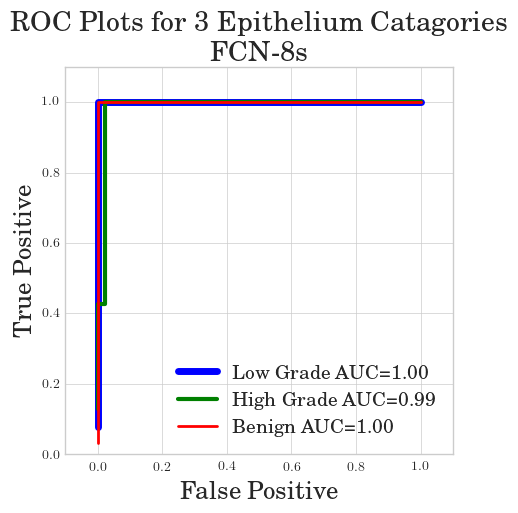

In [307]:
rep_file = '/Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s/_report_no_thresh.txt'

with open(rep_file, 'r') as f:
    log = f.read()
    
gr = []
lg = []
hg = []
bn = []
st = []
for r in re.findall(PATTERN, log):
    gr.append(GradeCode[r[0]])
    lg.append(float(r[1]))
    hg.append(float(r[2]))
    bn.append(float(r[3]))
    st.append(float(r[4]))
    
gr = np.asarray(gr)
lg = np.asarray(lg)
hg = np.asarray(hg)
bn = np.asarray(bn)
st = np.asarray(st)
# tp_pct = np.asarray(tp_pct)

# Combine high grades into a single label
gr[gr==2] = 1
gr[gr==3] = 2


# low grade = positive class
# search across % thresholds given low grade.

# scores should be the percent of the positive class
lg_scores = []
for l, h, b, s in zip(lg, hg, bn, st):
    lg_scores.append(pct_epithelium(l, l, h, b))
lg_scores = np.asarray(lg_scores)

hg_scores = []
for l, h, b, s in zip(lg, hg, bn, st):
    hg_scores.append(pct_epithelium(h, l, h, b))
hg_scores = np.asarray(hg_scores)

bn_scores = []
for l, h, b, s in zip(lg, hg, bn, st):
    bn_scores.append(pct_epithelium(b, l, h, b))
bn_scores = np.asarray(bn_scores)

# st_scores = []
# for l, h, b, s in zip(lg, hg, bn, st):
#     st_scores.append(pct_stroma(l, h, b, s))
# st_scores = np.asarray(st_scores)

lg_fpr, lg_tpr, lgthresholds = roc_curve(gr, lg_scores, pos_label=0, drop_intermediate=True)
hg_fpr, hg_tpr, hgthresholds = roc_curve(gr, hg_scores, pos_label=1, drop_intermediate=True)
bn_fpr, bn_tpr, bnthresholds = roc_curve(gr, bn_scores, pos_label=2, drop_intermediate=True)

lgauc = auc(lg_fpr, lg_tpr)
hgauc = auc(hg_fpr, hg_tpr)
bnauc = auc(bn_fpr, bn_tpr)
# st_fpr, st_tpr, thresholds = roc_curve(gr, st_scores, pos_label=3)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(lg_fpr, lg_tpr, lw=5, color='b', label='Low Grade AUC={:1.2f}'.format(lgauc))
ax.plot(hg_fpr, hg_tpr, lw=3, color='g', label='High Grade AUC={:1.2f}'.format(hgauc))
ax.plot(bn_fpr, bn_tpr, lw=2, color='r', label='Benign AUC={:1.2f}'.format(bnauc))

ax.set_ylabel('True Positive', fontsize=18)
ax.set_xlabel('False Positive', fontsize=18)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0, 1.1])
lgd = plt.legend(loc=4, fontsize=14)
ax.set_title('ROC Plots for 3 Epithelium Catagories\nFCN-8s', fontsize=20)

outfile = '/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/wsi/fcn_auc.pdf'
fig.savefig(outfile, bbox_inches='tight')

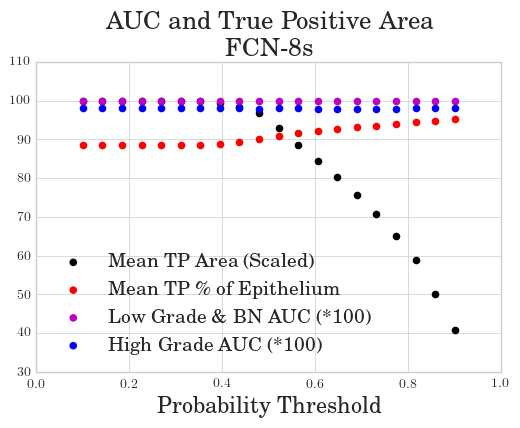

In [312]:
true_positives = []
tp_areas = []
all_areas = []
lgauc = []
hgauc = []
bnauc = []

for pct in thresholds:
    rep = '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic/_report_thresh{}.txt'.format(pct)

    with open(rep, 'r') as f:
        log = f.read()
        
    gr = []
    lg = []
    hg = []
    bn = []
    st = []
    for r in re.findall(PATTERN, log):
        gr.append(GradeCode[r[0]])
        
        if not np.isnan(float(r[1]) ):
            lg.append(float(r[1]))
        else:
            lg.append(1e-10)
            
        if not np.isnan(float(r[2]) ):
            hg.append(float(r[2]))
        else:
            hg.append(1e-10)
            
        if not np.isnan(float(r[3]) ):
            bn.append(float(r[3]))
        else:
            bn.append(1e-10)
            
        if not np.isnan(float(r[4]) ):
            st.append(float(r[4]))
        else:
            st.append(1e-10)

#     print len(gr)
#     print len(lg)
#     print len(hg)
#     print len(bn)
#     print len(st)
    gr = np.asarray(gr)
    lg = np.asarray(lg)
    hg = np.asarray(hg)
    bn = np.asarray(bn)
    st = np.asarray(st)
    
    gr[gr==2] = 1
    gr[gr==3] = 2
    
    lg_scores = []
    for l, h, b, s in zip(lg, hg, bn, st):
        lg_scores.append(pct_epithelium(l, l, h, b))
    lg_scores = np.asarray(lg_scores)

    hg_scores = []
    for l, h, b, s in zip(lg, hg, bn, st):
        hg_scores.append(pct_epithelium(h, l, h, b))
    hg_scores = np.asarray(hg_scores)

    bn_scores = []
    for l, h, b, s in zip(lg, hg, bn, st):
        bn_scores.append(pct_epithelium(b, l, h, b))
    bn_scores = np.asarray(bn_scores)

    # st_scores = []
    # for l, h, b, s in zip(lg, hg, bn, st):
    #     st_scores.append(pct_stroma(l, h, b, s))
    # st_scores = np.asarray(st_scores)

    lg_fpr, lg_tpr, lgthresholds = roc_curve(gr, lg_scores, pos_label=0, drop_intermediate=True)
    hg_fpr, hg_tpr, hgthresholds = roc_curve(gr, hg_scores, pos_label=1, drop_intermediate=True)
    bn_fpr, bn_tpr, bnthresholds = roc_curve(gr, bn_scores, pos_label=2, drop_intermediate=True)

    lgauc.append(auc(lg_fpr, lg_tpr))
    hgauc.append(auc(hg_fpr, hg_tpr))
    bnauc.append(auc(bn_fpr, bn_tpr))
    
        
    tp = []        
    for r in re.findall(TP_pattern, log):
        tp.append(float(r))
        
    tp_area = []        
    for r in re.findall(TP_AREA_pattern, log):
        tp_area.append(float(r))
        
    areas = []
    for r in re.findall(AREA_PATT, log):
        areas.append(float(r))
        
    true_positives.append(tp)
    all_areas.append(areas)
    tp_areas.append(tp_area)
    
# print true_positives

# tp_mean = [np.average(xx,weights=yy) for xx, yy in zip(true_positives, all_areas)]
# tp_area_mean = [np.average(xx,weights=yy) for xx, yy in zip(tp_areas, all_areas)]

tp_mean = [np.mean(xx) for xx in true_positives]
tp_area_mean = [np.mean(xx) for xx in tp_areas]
tp_area_mean = np.asarray(tp_area_mean)
tp_area_mean /= tp_area_mean.max()
tp_area_mean *= 100

lgauc = [xx*100 for xx in lgauc]
hgauc = [xx*100 for xx in hgauc]
bnauc = [xx*100 for xx in bnauc]

plt.scatter(thresholds, tp_area_mean, color='k', label='Mean TP Area (Scaled)')
plt.scatter(thresholds, tp_mean, color='r', label='Mean TP \% of Epithelium')
plt.scatter(thresholds, lgauc, color='m', label='Low Grade \& BN AUC (*100)')
plt.scatter(thresholds, hgauc, color='b', label='High Grade AUC (*100)')
# plt.scatter(thresholds, bnauc, color='g', label='BN AUC (*100)', s=15)

plt.legend(loc=3, fontsize=14)
plt.xlabel('Probability Threshold', fontsize=16)
plt.title('AUC and True Positive Area\nFCN-8s', fontsize=18)
# plt.ylim([0, 100])

plt.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/wsi/AUC_TP_vs_threshold.pdf', bbox_inches='tight')

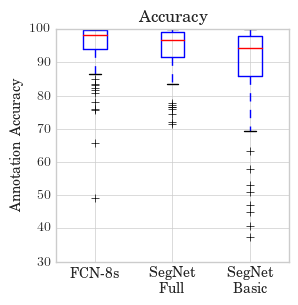

In [346]:
rep_files = ['/Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s/_report_no_thresh.txt',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_full/_report_no_thresh.txt',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic/_report_no_thresh.txt',
            ]
names = ['FCN-8s',
         'SegNet\nFull',
         'SegNet\nBasic']
tps = []   
fig, ax = plt.subplots(1,1,figsize=(3,3))

for rep_file in rep_files:
    with open(rep_file, 'r') as f:
        log = f.read()

    tp = []

    for r in re.findall(TP_pattern, log):
        tp.append(float(r))
    
    tps.append(tp)
    
ax.boxplot(tps)
ax.set_xticklabels(names)
ax.set_ylabel('Annotation Accuracy')
ax.set_title('Accuracy')

fig.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/wsi/annot_accuracy.pdf', bbox_inches='tight')

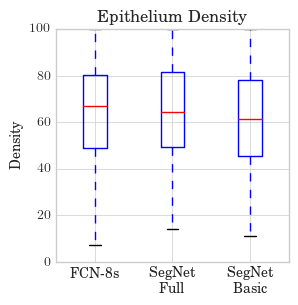

In [345]:
rep_files = ['/Users/nathaning/Dropbox/projects/semantic_pca/results/fcn8s/_report_no_thresh.txt',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_full/_report_no_thresh.txt',
             '/Users/nathaning/Dropbox/projects/semantic_pca/results/segnet_basic/_report_no_thresh.txt',
            ]
names = ['FCN-8s',
         'SegNet\nFull',
         'SegNet\nBasic']
tps = []  
total_areas = []
epithelium_areas = []
epith_density = []
fig, ax = plt.subplots(1,1,figsize=(3,3))

for rep_file in rep_files:
    with open(rep_file, 'r') as f:
        log = f.read()

    tp = []
    for r in re.findall(TP_pattern, log):
        tp.append(float(r))
    
    tps.append(tp)
    
    total_area = []
    epith_area = []
    for r in re.findall(PATTERN, log):
        epith_area.append(float(r[-1]))
        
    total_area = []
    for r in re.findall(AREA_PATT, log):
        total_area.append(float(r))
        
    total_areas.append(total_area)
    epithelium_areas.append(epith_area)
    
    epith_density.append([100*ep/tot for ep, tot in zip(epith_area, total_area)])
    
ax.boxplot(epith_density)

# ax.hist(epith_density[0], 5, alpha=0.3)
# ax.hist(epith_density[1], 5, alpha=0.3)
# ax.hist(epith_density[2], 5, alpha=0.3)

# ax.violinplot(epith_density)

ax.set_xticklabels(names)
# ax.set_xlabel('Density')
ax.set_ylabel('Density')
ax.set_title('Epithelium Density')


fig.savefig('/Users/nathaning/Dropbox/_Papers/pca segmentation/Figs/wsi/epi_density.pdf', bbox_inches='tight')